# MLP training on MNIST

In [13]:
# todo: init MLP and add the predict
# todo: add data loading in PyTorch
# todo: add the training loop, loss_fn

import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [14]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, key, scale=0.01):
  params = []
  keys = jax.random.split(key, num=len(layer_widths)-1)

  for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
    weight_key, bias_key = jax.random.split(key)
    params.append(
        [scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
         scale*jax.random.normal(bias_key, shape=(out_width,))]
    )

  return params

key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree.map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [15]:
def MLP_predict(params, x):
  hidden_layers = params[:-1]

  activation = x
  for w, b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w, activation) + b)

  w_last, b_last = params[-1]
  logits = jnp.dot(w_last, activation) + b_last

  return logits - logsumexp(logits)

# test single example
dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict =  vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


# Visualizations

In [16]:
def custom_transform(x):
  return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
  transposed_data = list(zip(*batch))

  labels = np.array(transposed_data[1])
  imgs = np.stack(transposed_data[0])

  return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - Loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


In [17]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
  predictions = batched_MLP_predict(params, imgs)

  return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
  pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
  return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.001):
  loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

  return loss, jax.tree.map(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):
  for cnt, (imgs, lbls) in enumerate(train_loader):
    gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
    loss, MLP_params = update(MLP_params, imgs, gt_labels)

    if cnt % 50 == 0:
      print(loss)

  print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

0.22609685
0.21552484
0.19396439
0.18211158
0.16907325
0.15062459
0.12781635
0.12361882
0.11515732
0.106291726
Epoch 0, train acc = 0.8027999997138977 test acc = 0.8154000043869019
0.089632265
0.09984415
0.08312095
0.09267376
0.07653828
0.07014528
0.08422338
0.058063645
0.06021854
0.05665483
Epoch 1, train acc = 0.8540666699409485 test acc = 0.8636999726295471
0.057929795
0.055723526
0.05954603
0.051448073
0.051477134
0.061321862
0.04192686
0.045966562
0.051262982
0.046075273
Epoch 2, train acc = 0.8752833604812622 test acc = 0.8849999904632568
0.041312616
0.050558567
0.05337261
0.039957162
0.058433235
0.04159364
0.046473846
0.028121948
0.045003124
0.04036655
Epoch 3, train acc = 0.8883833289146423 test acc = 0.8944000005722046
0.039104037
0.04804538
0.043820843
0.032421853
0.03206045
0.036104422
0.030237919
0.035892274
0.029826075
0.03619791
Epoch 4, train acc = 0.8964666724205017 test acc = 0.9025999903678894


(28, 28)
pred 7
gt 7


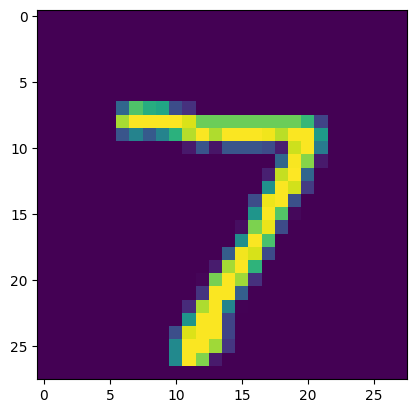

In [18]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

# Visualization

(512, 784)
(28, 28)


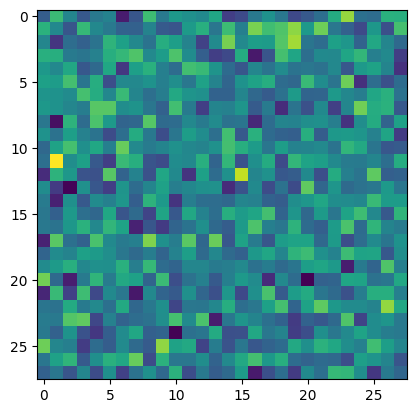

(<matplotlib.image.AxesImage at 0x7c12a6e2cdf0>, None)

In [19]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single), plt.show()

(128, 256)


KeyError: 7

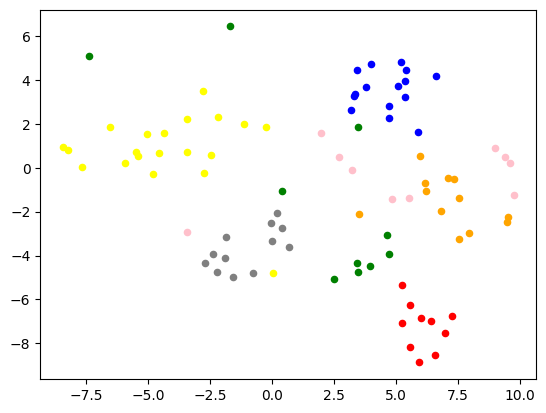

In [22]:
# Visualize embeddings using t-SNE
from sklearn.manifold import TSNE

def fetch_activation(params, x):
  hidden_layers = params[:-1]

  activation = x
  for w, b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w, activation) + b)

  return activation

batched_fetch_activation = vmap(fetch_activation, in_axes=(None, 0))
imgs, lbls = next(iter(test_loader))

batch_activations = batched_fetch_activation(MLP_params, imgs)
print(batch_activations.shape)  # (128, 2)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batch_activations)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

for class_id in range(10):
    plt.scatter(t_sne_embeddings[lbls == class_id, 0], t_sne_embeddings[lbls == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()

In [26]:
# dead neurons


def fetch_activations2(params, x):
    hidden_layers = params[:-1]
    collector = []

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)
        collector.append(activation)

    return collector


batched_fetch_activations2 = vmap(fetch_activations2, in_axes=(None, 0))

imgs, lbls = next(iter(test_loader))

MLP_params2 = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

batch_activations = batched_fetch_activations2(MLP_params2, imgs)
print(batch_activations[1].shape) # (128, 512/256)

dead_neurons = [np.ones(act.shape[1:]) for act in batch_activations]

for layer_id, activations in enumerate(batch_activations):
  dead_neurons[layer_id] = np.logical_and(dead_neurons[layer_id], (activations == 0).all(axis=0))

for layers in dead_neurons:
  print(np.sum(layers))

(128, 256)
0
7
